# **Overfitting comparison between the two models**

## **Preliminary steps**

In [ ]:
### PACKAGES

import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F


In [37]:
### FUNCTIONS AND CLASSES

from src.libs import preprocessing, visualization

from src.libs.tokenizer import CharacterLevelTokenizer

from src.model.bayes_transformer import BayesFormer

from src.model.transformer import Transformer


In [38]:
### DEVICE

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")


Using device: cpu


In [39]:
### SAVING PATH

SAVING_PATH = os.path.join("output", "overfitting")


## **Tokenizer**

In [40]:
### CREATE TOKENIZER

tokenizer = CharacterLevelTokenizer()

VOCAB_SIZE = tokenizer.ntokens

print(f"Vocabulary size: {VOCAB_SIZE}")


Vocabulary size: 14


## **Data**

In [55]:
### CONSTANTS

NUM_DIGITS = 2

TRAIN_SIZE = 1000
VALID_SIZE = 100
TEST_SIZE = 1000


In [56]:
### CREATE DATASETS

train_dataset = preprocessing.create_dataset(
    nb_samples=TRAIN_SIZE, num_digits=NUM_DIGITS
)

valid_dataset = preprocessing.create_dataset(
    nb_samples=VALID_SIZE, num_digits=NUM_DIGITS
)

test_dataset = preprocessing.create_dataset(nb_samples=TEST_SIZE, num_digits=NUM_DIGITS)


## **MODELS**

In [62]:
### ARCHITECTURE

NB_LAYERS = 2
NB_HEADS = 8
EMBEDDING_DIMENSION = 64
HEAD_SIZE = 8  # EMBEDDING_DIMENSION // NB_HEADS
CONTEXT_LENGTH = 20
HIDDEN_DIMENSION = 64
DROPOUT_TRANSFORMER = 0.1
DROPOUT_BAYESFORMER = 0.05


In [71]:
### TRANSFORMER

transformer = Transformer(
    vocab_size=VOCAB_SIZE,
    nb_layers=NB_LAYERS,
    nb_heads=NB_HEADS,
    embedding_dimension=EMBEDDING_DIMENSION,
    head_size=HEAD_SIZE,
    context_length=CONTEXT_LENGTH,
    hidden_dimension=HIDDEN_DIMENSION,
    dropout=DROPOUT_TRANSFORMER,
)

transformer.to(DEVICE)

print(
    "number of parameters: {}".format(
        sum([x.numel() for x in transformer.parameters()])
    )
)


number of parameters: 166542


In [72]:
### BAYESFORMER

bayesformer = BayesFormer(
    vocab_size=VOCAB_SIZE,
    nb_layers=NB_LAYERS,
    nb_heads=NB_HEADS,
    embedding_dimension=EMBEDDING_DIMENSION,
    head_size=HEAD_SIZE,
    context_length=CONTEXT_LENGTH,
    hidden_dimension=HIDDEN_DIMENSION,
    dropout=DROPOUT_BAYESFORMER,
)

bayesformer.to(DEVICE)

print(
    "number of parameters: {}".format(
        sum([x.numel() for x in bayesformer.parameters()])
    )
)


number of parameters: 166542


## **TRAINING**

In [73]:
### CONSTANTS

NB_EPOCHS = 100
BATCH_SIZE = 20
LEARNING_RATE = 1e-3

assert (
    TRAIN_SIZE % BATCH_SIZE == 0
    and VALID_SIZE % BATCH_SIZE == 0
    and TEST_SIZE % BATCH_SIZE == 0
), "BATCH_SIZE must be a divisor of TRAIN_SIZE, VALID_SIZE and TEST_SIZE"


In [74]:
### TRAINING FUNCTION


def train(
    model: Transformer | BayesFormer,
    model_name: str,
    train_dataset: list[tuple[str, str]],
    valid_dataset: list[tuple[str, str]],
) -> None:
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    valid_losses = []
    best_valid_loss = float("inf")
    for epoch in range(1, NB_EPOCHS + 1):
        train_loss = 0.0
        valid_loss = 0.0
        # Training
        model.train()
        for batch, i in enumerate(range(0, len(train_dataset) - 1, BATCH_SIZE)):
            prompts, target_answers, prompt_length, answers_length, _, _ = (
                preprocessing.get_batch(
                    dataset=train_dataset,
                    tokenizer=tokenizer,
                    i=i,
                    batch_size=BATCH_SIZE,
                )
            )
            prompts = prompts.to(DEVICE)  # (prompt_length, batch_size)
            target_answers = target_answers.to(
                DEVICE
            )  # (answers_length + 1, batch_size)
            input_tensor = torch.cat(
                (prompts, target_answers), 0
            )  # (prompt_length + answers_length + 1, batch_size)
            model.zero_grad()
            output = model(
                input_tensor
            )  # (prompt_length + answers_length + 1, batch_size, vocab_size)
            output_answers = output[prompt_length - 1 : -1, :, :].reshape(
                -1, VOCAB_SIZE
            )  # ((answers_length + 1) * batch_size, vocab_size)
            target_answers = target_answers.view(-1).long()
            loss = criterion(output_answers, target_answers)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        # Validation
        model.eval()
        with torch.no_grad():
            for batch, i in enumerate(range(0, len(valid_dataset) - 1, BATCH_SIZE)):
                prompts, target_answers, prompt_length, answers_length, _, _ = (
                    preprocessing.get_batch(
                        dataset=valid_dataset,
                        tokenizer=tokenizer,
                        i=i,
                        batch_size=BATCH_SIZE,
                    )
                )
                prompts = prompts.to(DEVICE)  # (prompt_length, batch_size)
                target_answers = target_answers.to(
                    DEVICE
                )  # (answers_length + 1, batch_size)
                input_tensor = torch.cat(
                    (prompts, target_answers), 0
                )  # (prompt_length + answers_length + 1, batch_size)
                output = model(input_tensor)
                output_answers = output[prompt_length - 1 : -1, :, :].reshape(
                    -1, VOCAB_SIZE
                )
                target_answers = target_answers.view(-1).long()
                loss = criterion(output_answers, target_answers)
                valid_loss += loss.item()
        train_loss = train_loss / len(train_dataset)
        valid_loss = valid_loss / len(valid_dataset)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        print(
            f"EPOCH [{epoch} / {NB_EPOCHS}] ----------- TRAIN LOSS : {train_loss:.4f}, VALID LOSS : {valid_loss:4f}"
        )
        # Save model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(
                model.state_dict(), os.path.join(SAVING_PATH, model_name + ".pt")
            )
    return np.array(train_losses), np.array(valid_losses)


In [75]:
### TRAIN TRANSFORMER

train_losses_transformer, valid_losses_transformer = train(
    model=transformer,
    model_name="transformer",
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
)


EPOCH [1 / 100] ----------- TRAIN LOSS : 0.0905, VALID LOSS : 0.083227
EPOCH [2 / 100] ----------- TRAIN LOSS : 0.0839, VALID LOSS : 0.082911
EPOCH [3 / 100] ----------- TRAIN LOSS : 0.0811, VALID LOSS : 0.079919
EPOCH [4 / 100] ----------- TRAIN LOSS : 0.0765, VALID LOSS : 0.076336
EPOCH [5 / 100] ----------- TRAIN LOSS : 0.0754, VALID LOSS : 0.073658
EPOCH [6 / 100] ----------- TRAIN LOSS : 0.0742, VALID LOSS : 0.073873
EPOCH [7 / 100] ----------- TRAIN LOSS : 0.0740, VALID LOSS : 0.072965
EPOCH [8 / 100] ----------- TRAIN LOSS : 0.0734, VALID LOSS : 0.073036
EPOCH [9 / 100] ----------- TRAIN LOSS : 0.0733, VALID LOSS : 0.072642
EPOCH [10 / 100] ----------- TRAIN LOSS : 0.0734, VALID LOSS : 0.072356
EPOCH [11 / 100] ----------- TRAIN LOSS : 0.0732, VALID LOSS : 0.072482
EPOCH [12 / 100] ----------- TRAIN LOSS : 0.0731, VALID LOSS : 0.072793
EPOCH [13 / 100] ----------- TRAIN LOSS : 0.0731, VALID LOSS : 0.073694
EPOCH [14 / 100] ----------- TRAIN LOSS : 0.0734, VALID LOSS : 0.072376
E

In [76]:
### TRAIN BAYESFORMER

train_losses_bayesformer, valid_losses_bayesformer = train(
    model=bayesformer,
    model_name="bayesformer",
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
)


EPOCH [1 / 100] ----------- TRAIN LOSS : 0.0912, VALID LOSS : 0.084522
EPOCH [2 / 100] ----------- TRAIN LOSS : 0.0851, VALID LOSS : 0.082707
EPOCH [3 / 100] ----------- TRAIN LOSS : 0.0813, VALID LOSS : 0.079593
EPOCH [4 / 100] ----------- TRAIN LOSS : 0.0764, VALID LOSS : 0.076001
EPOCH [5 / 100] ----------- TRAIN LOSS : 0.0767, VALID LOSS : 0.076266
EPOCH [6 / 100] ----------- TRAIN LOSS : 0.0750, VALID LOSS : 0.073511
EPOCH [7 / 100] ----------- TRAIN LOSS : 0.0747, VALID LOSS : 0.073015
EPOCH [8 / 100] ----------- TRAIN LOSS : 0.0745, VALID LOSS : 0.072735
EPOCH [9 / 100] ----------- TRAIN LOSS : 0.0744, VALID LOSS : 0.073785
EPOCH [10 / 100] ----------- TRAIN LOSS : 0.0744, VALID LOSS : 0.073319
EPOCH [11 / 100] ----------- TRAIN LOSS : 0.0739, VALID LOSS : 0.073402
EPOCH [12 / 100] ----------- TRAIN LOSS : 0.0742, VALID LOSS : 0.073773
EPOCH [13 / 100] ----------- TRAIN LOSS : 0.0739, VALID LOSS : 0.073262
EPOCH [14 / 100] ----------- TRAIN LOSS : 0.0738, VALID LOSS : 0.072252
E

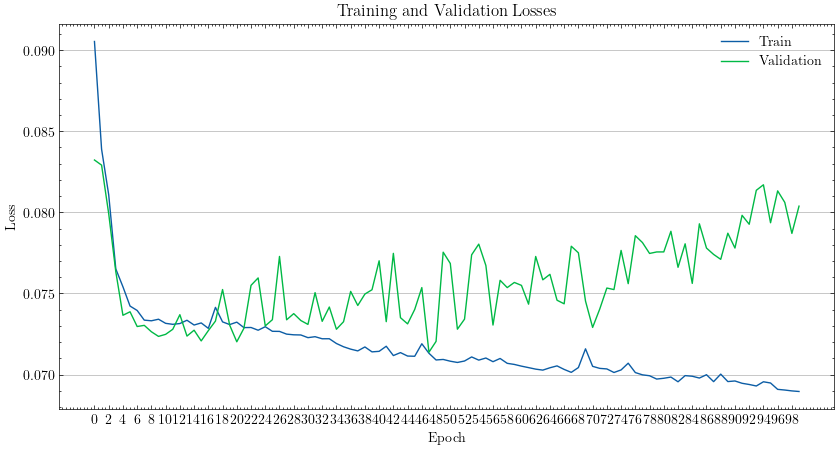

In [77]:
### PLOT TRANSFORMER LOSSES

visualization.plot_losses(
    train_losses=train_losses_transformer, valid_losses=valid_losses_transformer
)


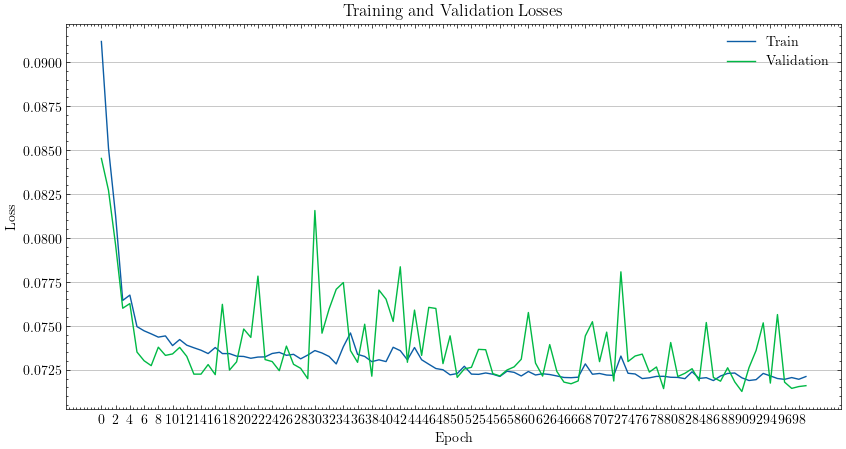

In [78]:
### PLOT BAYESFORMER LOSSES

visualization.plot_losses(
    train_losses=train_losses_bayesformer, valid_losses=valid_losses_bayesformer
)


## **Evaluation**

In [ ]:
### GENERATION FUNCTION


def generate(
    model: Transformer | BayesFormer,
    prompts: torch.Tensor,
    new_tokens: int,
    mode: str = "greedy",
    num_samples: int = 1,
    temperature: float = 0.8,
):
    input_tensor = torch.repeat_interleave(prompts, repeats=num_samples, dim=1).to(
        DEVICE
    )
    # (prompt_length, batch_size * num_samples)
    for _ in range(new_tokens):
        output = model(
            input_tensor
        )  # (prompt_length, batch_size * num_samples, ntokens)
        logits = output[-1, :, :]  # (batch_size * num_samples, ntokens)
        if mode == "greedy":
            tokens = torch.argmax(logits, -1).view(
                (1, -1)
            )  # (1, batch_size * num_samples)
        else:  # mode == "sampling"
            logits /= temperature
            probs = torch.softmax(logits, dim=-1)
            tokens = torch.multinomial(probs, num_samples=1).view(
                (1, -1)
            )  # (1, batch_size * num_samples)
        input_tensor = torch.cat((input_tensor, tokens), 0)
    return input_tensor


In [80]:
### EVALUATION FUNCTION


def evaluate(model: Transformer | BayesFormer, dataset: list[tuple[str, str]]):
    # Turn on evaluation mode disables dropout.
    model.eval()
    correct = 0.0
    with torch.no_grad():
        for batch, i in enumerate(range(0, len(dataset) - 1, BATCH_SIZE)):
            prompts, target_answers, prompt_length, answers_length, _, _ = (
                preprocessing.get_batch(dataset, tokenizer, i, BATCH_SIZE)
            )
            prompts = prompts.to(DEVICE)  # (prompt_length, batch_size)
            target_answers = target_answers.to(
                DEVICE
            )  # (answers_length + 1, batch_size)
            output = generate(
                model, prompts, answers_length + 1
            )  # (prompt_length + answers_length + 1, batch_size)
            answers_tokens = output[
                prompt_length:, :
            ]  # (answers_length + 1, batch_size), contains tokens
            equality_test = (
                answers_tokens == target_answers
            )  # (answers_length + 1, batch_size), contains boolean values
            correct += torch.all(equality_test, axis=0).float().sum()
        accuracy = correct / len(dataset)
    return accuracy.item()


In [84]:
### EVALUATE TRANSFORMER

accuracy_test_transformer = evaluate(model=transformer, dataset=test_dataset)
print(f"Transformer accuracy on test set: {accuracy_test_transformer:.2f}")

### EXAMPLES

transformer.eval()

for i in range(5):
    prompt, answers = test_dataset[i]
    prompt_tensor = torch.tensor(tokenizer.encode(prompt)).view((-1, 1))
    output = generate(transformer, prompt_tensor, len(answers) + 1).view((1, -1))
    print(tokenizer.decode(output.tolist()[0]) + "\t actual result: " + answers)


Transformer accuracy on test set: 0.01
41+66=120<EOS>	 actual result: 107
85+02=120	 actual result: 87
11+61=120	 actual result: 72
25+28=120	 actual result: 53
39+93=120<EOS>	 actual result: 132


In [82]:
### EVALUATE BAYESFORMER

accuracy_test_bayesformer = evaluate(model=bayesformer, dataset=test_dataset)
print(f"Bayesformer accuracy on test set: {accuracy_test_bayesformer:.2f}")

### EXAMPLES

bayesformer.eval()

for i in range(5):
    prompt, answers = test_dataset[i]
    prompt_tensor = torch.tensor(tokenizer.encode(prompt)).view((-1, 1))
    output = generate(bayesformer, prompt_tensor, len(answers) + 1).view((1, -1))
    print(tokenizer.decode(output.tolist()[0]) + "\t actual result: " + answers)


Bayesformer accuracy on test set: 0.00
41+66=10<EOS><EOS>	 actual result: 107
85+02=10<EOS>	 actual result: 87
11+61=10<EOS>	 actual result: 72
25+28=10<EOS>	 actual result: 53
39+93=10<EOS><EOS>	 actual result: 132
